In [98]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import seaborn as sns
from sklearn.preprocessing import LabelEncoder

In [99]:
# 폰트 한글화 세팅

# # window font setting
# font_path = 'C:/Windows/Fonts/batang.ttc'           # 한글 폰트를 적용하여 시각화

# # PJE font setting
# plt.rcParams['font.family'] = 'Malgun Gothic' 

# mac font setting
font_path = '/Library/Fonts/Arial Unicode.ttf'
font = fm.FontProperties(fname=font_path).get_name()
matplotlib.rc('font', family=font)

In [100]:
# CSV 파일 읽기
phone_df = pd.read_csv('./data/phone_information2.csv', low_memory=False)

전처리 1

In [101]:
# 인코딩

# 범주형 변수 전처리
le = LabelEncoder()
categorical_features = ['service_purchase_21', 'money_transfer_21']

# 범주형 변수 인코딩
for feature in categorical_features:
    phone_df[feature] = le.fit_transform(phone_df[feature].astype(str))

# # 데이터 값을 unique로 찍어본 결과 str로 들어가있는 데이터가 있어 int로 형변환 해주어야 함
# object 타입인 컬럼들 찾기
object_columns = phone_df.select_dtypes(include=['object']).columns

# object 타입 컬럼들을 숫자형으로 변환
for col in object_columns:
    phone_df.loc[:, col] = pd.to_numeric(phone_df[col], errors='coerce').astype('Int64')

# # 2
# for col in object_columns:
#     phone_df.loc[:, col] = pd.to_numeric(phone_df[col], errors='coerce').astype('float64')


# NA값이 있는 컬럼들 확인
na_columns = phone_df.columns[phone_df.isna().any()].tolist()
# NA가 있는 행을 모두 제거
phone_df = phone_df.dropna()

전처리 2

In [102]:
# xxs, xxx를 제거하는 코드 
phone_df = phone_df[(phone_df['brand_21'] == 1) |
                    (phone_df['brand_22'] == 1) ]

def create_brand_check(row):
    check = ""
    for i in range(21, 24):  # 21, 22, 23에 대해서
        brand_col = f'brand_{i}'
        if row[brand_col] == 1:
            check += 's'  # 삼성(1)이면 x로 표시
        else:
            check += 'x'  # 그 외 브랜드는 0으로 표시
    return check

phone_df['brand_check'] = phone_df.apply(create_brand_check, axis=1)
# phone_df['brand_check'].unique()

# churn 컬럼 생성
phone_df['churn'] = phone_df['brand_check'].apply(lambda x: 0 if x in ['sss', 'xss'] else 1)

In [103]:
# pd.set_option('display.max_columns', None)  # 모든 컬럼 출력
# print(phone_df.columns)

In [104]:
# 가장 최근 삼성을 사용한 연도를 찾기
def get_last_samsung_year(row):
    for i in [23, 22, 21]:  # 최신 연도부터 확인
        if row[f'brand_{i}'] == 1:
            return i
    return None

phone_df['last_samsung_year'] = phone_df.apply(get_last_samsung_year, axis=1)

# `_21`, `_22`, `_23`을 제거한 새로운 컬럼 생성
base_columns = list(set([col.rsplit('_', 1)[0] for col in phone_df.columns if '_' in col and 'brand' not in col]))

for col in base_columns:
    phone_df[col] = phone_df.apply(lambda row: row.get(f"{col}_{row['last_samsung_year']}", None) if row['last_samsung_year'] else None, axis=1)

# 필요 없는 컬럼 삭제
drop_cols = [col for col in phone_df.columns if any(suffix in col for suffix in ['_21', '_22', '_23'])]
phone_df = phone_df.drop(columns=drop_cols)

# 컬럼 정리
phone_df = phone_df[['churn'] + base_columns]

# print(phone_df.info())

---

# 1. CATBoost

0:	learn: 0.6153856	test: 0.6168280	best: 0.6168280 (0)	total: 2.5ms	remaining: 1.25s
100:	learn: 0.2672626	test: 0.3512687	best: 0.3505803 (92)	total: 202ms	remaining: 798ms
200:	learn: 0.2135453	test: 0.3481636	best: 0.3463341 (166)	total: 425ms	remaining: 633ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.3463340712
bestIteration = 166

Shrink model to first 167 iterations.
📌 Accuracy: 0.8730
📌 Precision: 0.5814
📌 Recall: 0.1295
📌 F1-score: 0.2119
📌 ROC-AUC: 0.7339

📌 Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.99      0.93      1272
           1       0.58      0.13      0.21       193

    accuracy                           0.87      1465
   macro avg       0.73      0.56      0.57      1465
weighted avg       0.84      0.87      0.84      1465



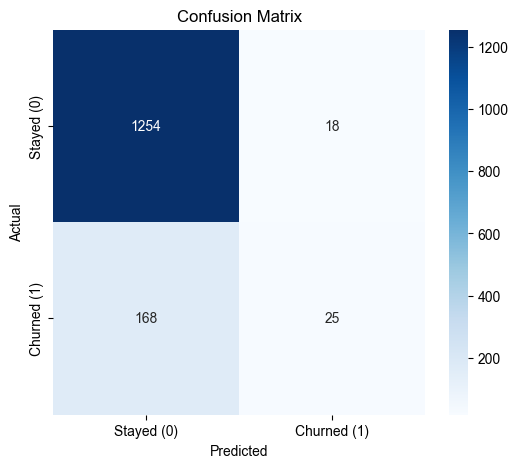

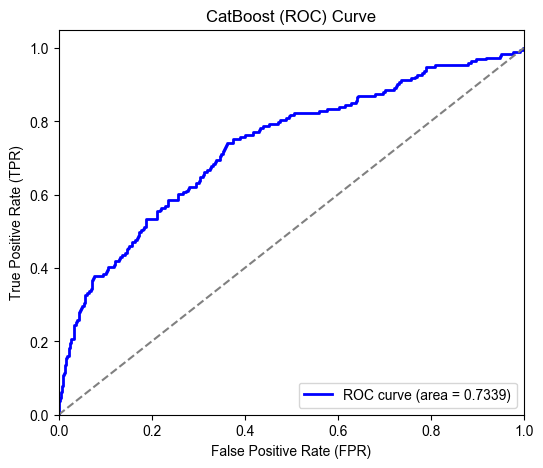

In [105]:
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns

# X, y 분리
X = phone_df.drop(columns=['churn', 'last_samsung'])
y = phone_df['churn']

# 학습/테스트 데이터 분리
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# CatBoost 모델 생성 및 학습
model = CatBoostClassifier(iterations=500, depth=6, learning_rate=0.1, loss_function='Logloss', verbose=100)
model.fit(X_train, y_train, eval_set=(X_test, y_test), early_stopping_rounds=50)

# 예측
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]  # 양성 클래스 확률

# 평가 지표 계산
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_prob)

# 오차 행렬
conf_matrix = confusion_matrix(y_test, y_pred)

# 결과 출력
print(f"📌 Accuracy: {accuracy:.4f}")
print(f"📌 Precision: {precision:.4f}")
print(f"📌 Recall: {recall:.4f}")
print(f"📌 F1-score: {f1:.4f}")
print(f"📌 ROC-AUC: {roc_auc:.4f}")
print("\n📌 Classification Report:\n", classification_report(y_test, y_pred))

# 오차 행렬 시각화
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Stayed (0)", "Churned (1)"], yticklabels=["Stayed (0)", "Churned (1)"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# ROC Curve 시각화
fpr, tpr, _ = roc_curve(y_test, y_prob)

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, color="blue", lw=2, label=f"ROC curve (area = {roc_auc:.4f})")
plt.plot([0, 1], [0, 1], color="gray", linestyle="--")  # 랜덤 모델 기준선
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.title("CatBoost (ROC) Curve")
plt.legend(loc="lower right")
plt.show()


# 1-1 CATBoost 오버샘플링

0:	learn: 0.6398195	test: 0.6810942	best: 0.6810942 (0)	total: 2.92ms	remaining: 1.45s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.6631574671
bestIteration = 7

Shrink model to first 8 iterations.
📌 Accuracy: 0.7741
📌 Precision: 0.2870
📌 Recall: 0.4819
📌 F1-score: 0.3598
📌 ROC-AUC: 0.6886

📌 Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.82      0.86      1272
           1       0.29      0.48      0.36       193

    accuracy                           0.77      1465
   macro avg       0.60      0.65      0.61      1465
weighted avg       0.83      0.77      0.80      1465



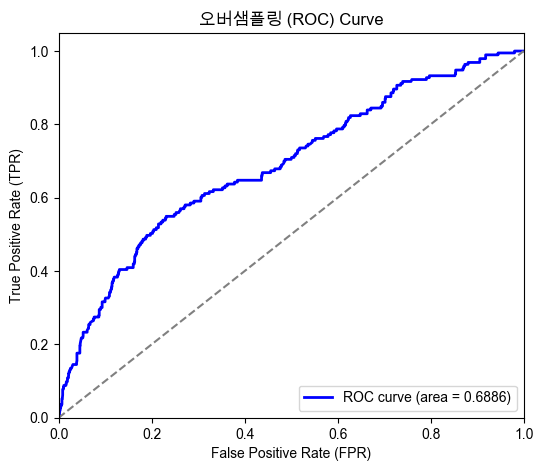

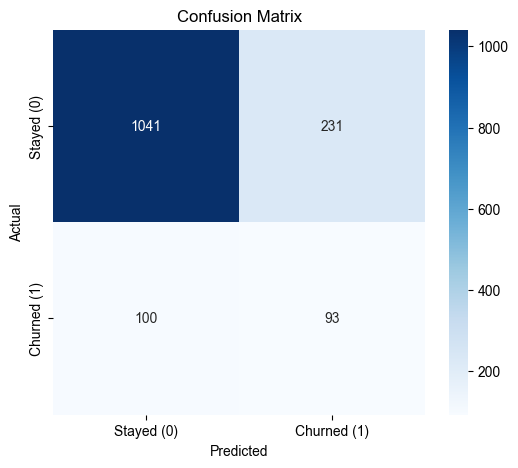

In [106]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report

# X, y 분리
X = phone_df.drop(columns=['churn', 'last_samsung'])
y = phone_df['churn']

# 학습/테스트 데이터 분리
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# SMOTE 오버샘플링
smote = SMOTE(sampling_strategy=0.5, random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

# CatBoost 모델 학습
model = CatBoostClassifier(iterations=500, depth=6, learning_rate=0.1, loss_function='Logloss', scale_pos_weight=6,  verbose=100)
model.fit(X_train_res, y_train_res, eval_set=(X_test, y_test), early_stopping_rounds=50)

# 예측
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]

# 추가⭐ 
from sklearn.metrics import precision_recall_curve
y_prob = model.predict_proba(X_test)[:, 1]
precisions, recalls, thresholds = precision_recall_curve(y_test, y_prob)

# 가장 적절한 지점 찾기 (F1-score 최대화)
f1_scores = (2 * precisions * recalls) / (precisions + recalls + 1e-9)
best_threshold = thresholds[f1_scores.argmax()]

# 최적 임계값 적용
y_pred = (y_prob > best_threshold).astype(int)
#⭐

# 평가 지표 계산
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_prob)

# 결과 출력
print(f"📌 Accuracy: {accuracy:.4f}")
print(f"📌 Precision: {precision:.4f}")
print(f"📌 Recall: {recall:.4f}")
print(f"📌 F1-score: {f1:.4f}")
print(f"📌 ROC-AUC: {roc_auc:.4f}")
print("\n📌 Classification Report:\n", classification_report(y_test, y_pred))

# ROC Curve 시각화
fpr, tpr, _ = roc_curve(y_test, y_prob)

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, color="blue", lw=2, label=f"ROC curve (area = {roc_auc:.4f})")
plt.plot([0, 1], [0, 1], color="gray", linestyle="--") 
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.title("오버샘플링 (ROC) Curve")
plt.legend(loc="lower right")
plt.show()

# 오차 행렬
conf_matrix = confusion_matrix(y_test, y_pred)
# 오차 행렬 시각화
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Stayed (0)", "Churned (1)"], yticklabels=["Stayed (0)", "Churned (1)"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

---

# 2. LightGBM

[LightGBM] [Info] Number of positive: 772, number of negative: 5087
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000216 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 328
[LightGBM] [Info] Number of data points in the train set: 5859, number of used features: 23
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
📌 Accuracy: 0.8396
📌 Precision: 0.4000
📌 Recall: 0.4352
📌 F1-score: 0.4169
📌 ROC-AUC: 0.7356

📌 Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.90      0.91      1272
           1       0.40      0.44      0.42       193

    accuracy                           0.84      1465
   macro avg       0.66      0.67      0.66      1465
weighted avg       0.85      0.84      0.84      1465



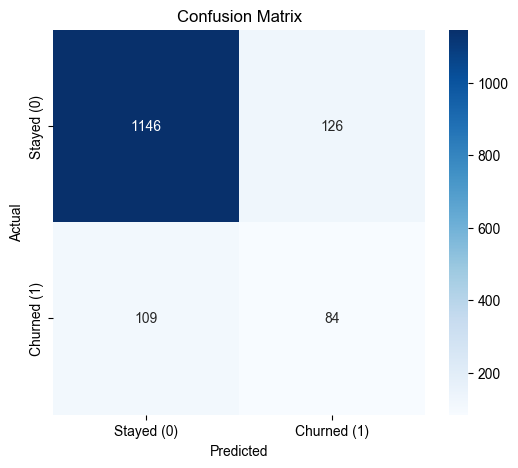

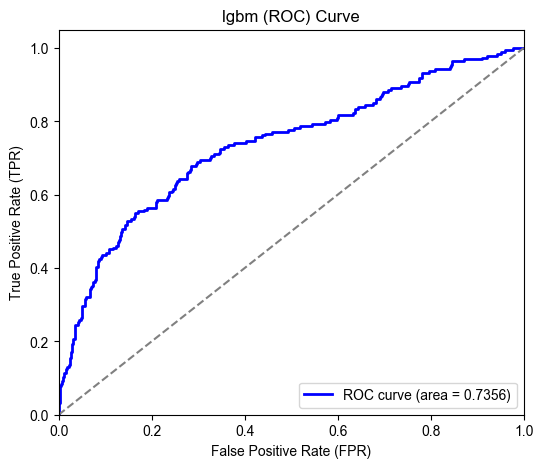

In [107]:
from lightgbm import LGBMClassifier

lgbm = LGBMClassifier(class_weight='balanced', num_leaves=31, learning_rate=0.05,
                      n_estimators=500, random_state=42)
lgbm.fit(X_train, y_train)
# 예측
y_pred = lgbm.predict(X_test)
y_prob = lgbm.predict_proba(X_test)[:, 1]  # 양성 클래스 확률

# 평가 지표 계산
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_prob)

# 오차 행렬
conf_matrix = confusion_matrix(y_test, y_pred)

# 결과 출력
print(f"📌 Accuracy: {accuracy:.4f}")
print(f"📌 Precision: {precision:.4f}")
print(f"📌 Recall: {recall:.4f}")
print(f"📌 F1-score: {f1:.4f}")
print(f"📌 ROC-AUC: {roc_auc:.4f}")
print("\n📌 Classification Report:\n", classification_report(y_test, y_pred))

# 오차 행렬 시각화
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Stayed (0)", "Churned (1)"], yticklabels=["Stayed (0)", "Churned (1)"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# ROC Curve 시각화
fpr, tpr, _ = roc_curve(y_test, y_prob)

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, color="blue", lw=2, label=f"ROC curve (area = {roc_auc:.4f})")
plt.plot([0, 1], [0, 1], color="gray", linestyle="--")  # 랜덤 모델 기준선
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.title("lgbm (ROC) Curve")
plt.legend(loc="lower right")
plt.show()


In [ ]:
# # 원하는 부분에 모델 저장
# import joblib

# # Random Forest 모델 저장
# joblib.dump(lgbm, 'models/LightGBM_model.joblib')

# # 특성 중요도와 성능 지표 저장
# import json
# model_metrics = {
#     'accuracy': accuracy,
#     'f1_score': f1,
#     'feature_importance': lgbm.feature_importances_.tolist(),
#     'feature_names': X.columns.tolist()
# }

# with open('models/lgbm_metrics.json', 'w') as f:
#     json.dump(model_metrics, f)

# 2-1 LightGBM 오버샘플링

[LightGBM] [Info] Number of positive: 2543, number of negative: 5087
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000292 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 340
[LightGBM] [Info] Number of data points in the train set: 7630, number of used features: 23
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
📌 Accuracy: 0.8294
📌 Precision: 0.3636
📌 Recall: 0.3938
📌 F1-score: 0.3781
📌 ROC-AUC: 0.7181

📌 Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.90      0.90      1272
           1       0.36      0.39      0.38       193

    accuracy                           0.83      1465
   macro avg       0.64      0.64      0.64      1465
weighted avg       0.84      0.83      0.83      1465



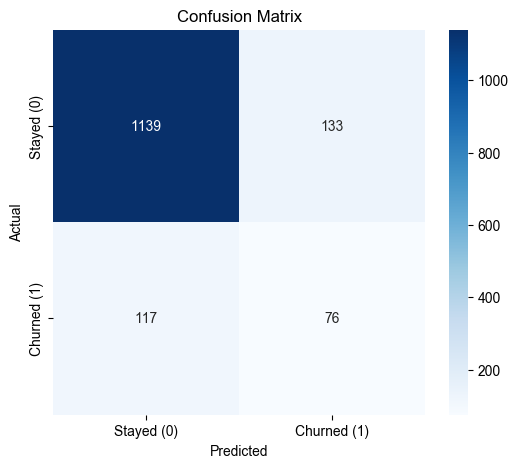

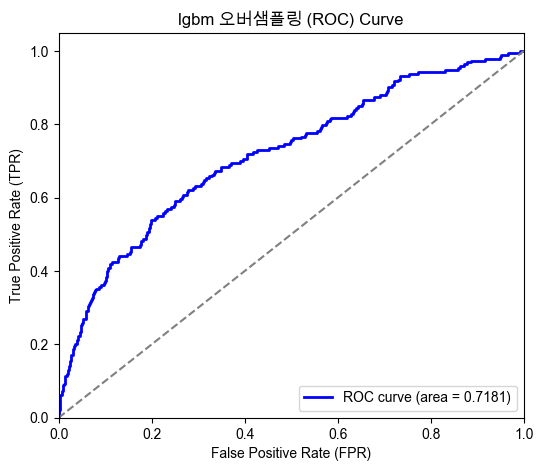

In [108]:
# SMOTE 오버샘플링
smote = SMOTE(sampling_strategy=0.5, random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

lgbm = LGBMClassifier(class_weight='balanced', num_leaves=31, learning_rate=0.05,
                      n_estimators=500, random_state=42)
lgbm.fit(X_train_res, y_train_res, eval_set=(X_test, y_test))

# 예측
y_pred = lgbm.predict(X_test)
y_prob = lgbm.predict_proba(X_test)[:, 1]  # 양성 클래스 확률

# 평가 지표 계산
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_prob)

# 오차 행렬
conf_matrix = confusion_matrix(y_test, y_pred)

# 결과 출력
print(f"📌 Accuracy: {accuracy:.4f}")
print(f"📌 Precision: {precision:.4f}")
print(f"📌 Recall: {recall:.4f}")
print(f"📌 F1-score: {f1:.4f}")
print(f"📌 ROC-AUC: {roc_auc:.4f}")
print("\n📌 Classification Report:\n", classification_report(y_test, y_pred))

# 오차 행렬 시각화
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Stayed (0)", "Churned (1)"], yticklabels=["Stayed (0)", "Churned (1)"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# ROC Curve 시각화
fpr, tpr, _ = roc_curve(y_test, y_prob)

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, color="blue", lw=2, label=f"ROC curve (area = {roc_auc:.4f})")
plt.plot([0, 1], [0, 1], color="gray", linestyle="--")  # 랜덤 모델 기준선
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.title("lgbm 오버샘플링 (ROC) Curve")
plt.legend(loc="lower right")
plt.show()

---

# 3. XGBoost

📌 Accuracy: 0.7850
📌 Precision: 0.2939
📌 Recall: 0.4508
📌 F1-score: 0.3558
📌 ROC-AUC: 0.6978

📌 Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.84      0.87      1272
           1       0.29      0.45      0.36       193

    accuracy                           0.78      1465
   macro avg       0.60      0.64      0.61      1465
weighted avg       0.83      0.78      0.80      1465



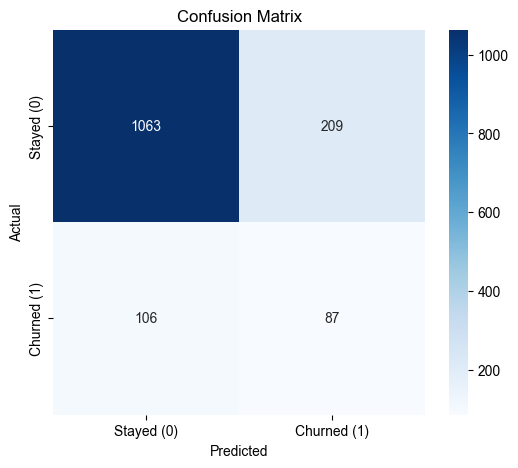

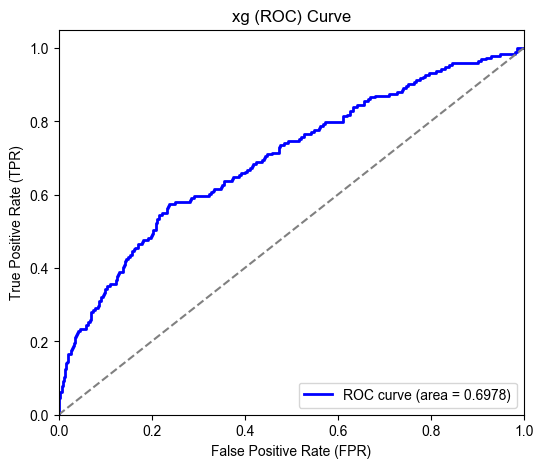

In [109]:
from xgboost import XGBClassifier

xgb = XGBClassifier(scale_pos_weight=len(y_train[y_train == 0]) / len(y_train[y_train == 1]),
                    max_depth=5, learning_rate=0.05, n_estimators=400, random_state=42)
xgb.fit(X_train, y_train)

# 예측
y_pred = xgb.predict(X_test)
y_prob = xgb.predict_proba(X_test)[:, 1]  # 양성 클래스 확률

# 평가 지표 계산
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_prob)

# 오차 행렬
conf_matrix = confusion_matrix(y_test, y_pred)

# 결과 출력
print(f"📌 Accuracy: {accuracy:.4f}")
print(f"📌 Precision: {precision:.4f}")
print(f"📌 Recall: {recall:.4f}")
print(f"📌 F1-score: {f1:.4f}")
print(f"📌 ROC-AUC: {roc_auc:.4f}")
print("\n📌 Classification Report:\n", classification_report(y_test, y_pred))

# 오차 행렬 시각화
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Stayed (0)", "Churned (1)"], yticklabels=["Stayed (0)", "Churned (1)"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# ROC Curve 시각화
fpr, tpr, _ = roc_curve(y_test, y_prob)

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, color="blue", lw=2, label=f"ROC curve (area = {roc_auc:.4f})")
plt.plot([0, 1], [0, 1], color="gray", linestyle="--")  # 랜덤 모델 기준선
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.title("xg (ROC) Curve")
plt.legend(loc="lower right")
plt.show()


# 3-1 XGBoost 오버샘플링

[0]	validation_0-logloss:1.18978
[1]	validation_0-logloss:1.16219
[2]	validation_0-logloss:1.13704
[3]	validation_0-logloss:1.11435
[4]	validation_0-logloss:1.09342
[5]	validation_0-logloss:1.07507
[6]	validation_0-logloss:1.05870
[7]	validation_0-logloss:1.04338
[8]	validation_0-logloss:1.02873
[9]	validation_0-logloss:1.01562
[10]	validation_0-logloss:1.00447
[11]	validation_0-logloss:0.99287
[12]	validation_0-logloss:0.98288
[13]	validation_0-logloss:0.97373
[14]	validation_0-logloss:0.96494
[15]	validation_0-logloss:0.95727
[16]	validation_0-logloss:0.94913
[17]	validation_0-logloss:0.94192
[18]	validation_0-logloss:0.93540
[19]	validation_0-logloss:0.92887
[20]	validation_0-logloss:0.92311
[21]	validation_0-logloss:0.91733
[22]	validation_0-logloss:0.91136
[23]	validation_0-logloss:0.90568
[24]	validation_0-logloss:0.89996
[25]	validation_0-logloss:0.89600
[26]	validation_0-logloss:0.89166
[27]	validation_0-logloss:0.88702
[28]	validation_0-logloss:0.88223
[29]	validation_0-loglos

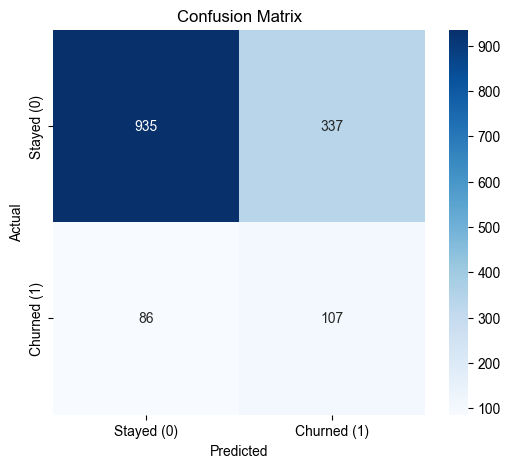

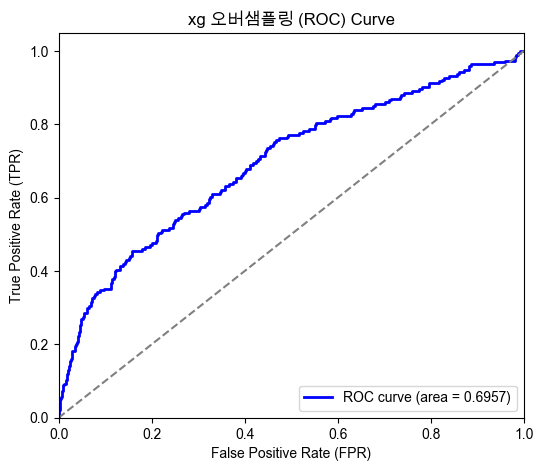

📌 Accuracy: 0.7113
📌 Precision: 0.2410
📌 Recall: 0.5544
📌 F1-score: 0.3359
📌 ROC-AUC: 0.6957

📌 Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.74      0.82      1272
           1       0.24      0.55      0.34       193

    accuracy                           0.71      1465
   macro avg       0.58      0.64      0.58      1465
weighted avg       0.83      0.71      0.75      1465



In [110]:
# SMOTE 오버샘플링
smote = SMOTE(sampling_strategy=0.5, random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

xgb = XGBClassifier(scale_pos_weight=len(y_train[y_train == 0]) / len(y_train[y_train == 1]),
                    max_depth=5, learning_rate=0.05, n_estimators=400, random_state=42)
xgb.fit(X_train_res, y_train_res, eval_set=[(X_test, y_test)])

# 예측
y_pred = xgb.predict(X_test)
y_prob = xgb.predict_proba(X_test)[:, 1]  # 양성 클래스 확률

# 평가 지표 계산
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_prob)

# 오차 행렬
conf_matrix = confusion_matrix(y_test, y_pred)


# 오차 행렬 시각화
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Stayed (0)", "Churned (1)"], yticklabels=["Stayed (0)", "Churned (1)"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# ROC Curve 시각화
fpr, tpr, _ = roc_curve(y_test, y_prob)

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, color="blue", lw=2, label=f"ROC curve (area = {roc_auc:.4f})")
plt.plot([0, 1], [0, 1], color="gray", linestyle="--")  # 랜덤 모델 기준선
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.title("xg 오버샘플링 (ROC) Curve")
plt.legend(loc="lower right")
plt.show()

# 결과 출력
print(f"📌 Accuracy: {accuracy:.4f}")
print(f"📌 Precision: {precision:.4f}")
print(f"📌 Recall: {recall:.4f}")
print(f"📌 F1-score: {f1:.4f}")
print(f"📌 ROC-AUC: {roc_auc:.4f}")
print("\n📌 Classification Report:\n", classification_report(y_test, y_pred))


In [121]:
# 원하는 부분에 모델 저장
import joblib

# Random Forest 모델 저장
joblib.dump(xgb, 'models/XGBoost_model.joblib')

# 특성 중요도와 성능 지표 저장
import json
model_metrics = {
    'accuracy': accuracy,
    'f1_score': f1,
    'feature_importance': xgb.feature_importances_.tolist(),
    'feature_names': X.columns.tolist()
}

with open('models/xgb_metrics.json', 'w') as f:
    json.dump(model_metrics, f)

----
# 2. 파생 변수들을 추가

In [111]:
# 비용 관련 파생변수:

#소득 대비 총 비용 비율
phone_df['cost_to_income_ratio'] = (phone_df['machine_purchase'] + phone_df['agency_purchase']) / phone_df['salary']

#월 통신비의 소득 대비 비율
phone_df['agency_to_income_ratio'] = phone_df['agency_purchase'] / phone_df['salary']

#기기 가격의 소득 대비 비율
phone_df['device_to_income_ratio'] = phone_df['machine_purchase'] / phone_df['salary']

#서비스 활용도 관련 파생변수:

# 전체 서비스 사용 점수
phone_df['total_service_score'] = phone_df[['email', 'messenger', 'blog', 
                             'cloud', 'call_check']].sum(axis=1)

#금융 서비스 활용도
phone_df['financial_service_score'] = phone_df[['money_transfer', 
                                  'cradit_card']].sum(axis=1)

# 통신 서비스 활용도
phone_df['telecom_service_score'] = phone_df[['voice_service', 
                                'data_service']].sum(axis=1)


# 생애주기 점수 (나이, 결혼여부, 직업 조합)
phone_df['lifecycle_score'] = phone_df['age'] + phone_df['marry'] * 10 + phone_df['job'] * 5

# 상호작용 변수:

# 서비스 활용도와 소득 수준의 상호작용
phone_df['service_income_interaction'] = phone_df['total_service_score'] * phone_df['salary']

# 연령과 서비스 활용도의 상호작용
phone_df['age_service_interaction'] = phone_df['age'] * phone_df['total_service_score']

# 통신비와 서비스 활용도의 상호작용
phone_df['cost_service_interaction'] = phone_df['agency_purchase'] * phone_df['total_service_score']

# 복합 지표:
 
# 고객 가치 점수
phone_df['customer_value_score'] = (
    phone_df['salary'] * 0.3 +
    phone_df['total_service_score'] * 0.3 +
    phone_df['agency_purchase'] * 0.2 +
    phone_df['use_date'] * 0.2
)

# 이탈 위험 점수
phone_df['churn_risk_score'] = (
    phone_df['cost_to_income_ratio'] * 0.4 +
    (1 - phone_df['total_service_score']/phone_df['total_service_score'].max()) * 0.3 +
    (1 - phone_df['use_date']/phone_df['use_date'].max()) * 0.3
)



# 1-2 CATBoost 

파생변수 + 기존 변수들 중 특성 중요도 높은 18개 변수로 학습 

0:	learn: 0.6141304	test: 0.6155550	best: 0.6155550 (0)	total: 1.88ms	remaining: 938ms
100:	learn: 0.2748105	test: 0.3503509	best: 0.3499807 (84)	total: 344ms	remaining: 1.36s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.3499806618
bestIteration = 84

Shrink model to first 85 iterations.
📌 Accuracy: 0.8730
📌 Precision: 0.6296
📌 Recall: 0.0881
📌 F1-score: 0.1545
📌 ROC-AUC: 0.7130

📌 Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.99      0.93      1272
           1       0.63      0.09      0.15       193

    accuracy                           0.87      1465
   macro avg       0.75      0.54      0.54      1465
weighted avg       0.84      0.87      0.83      1465



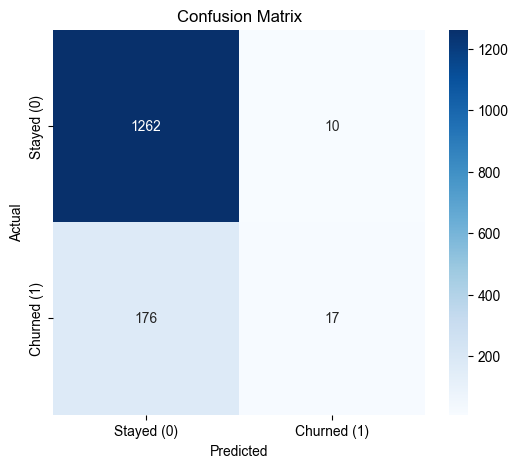

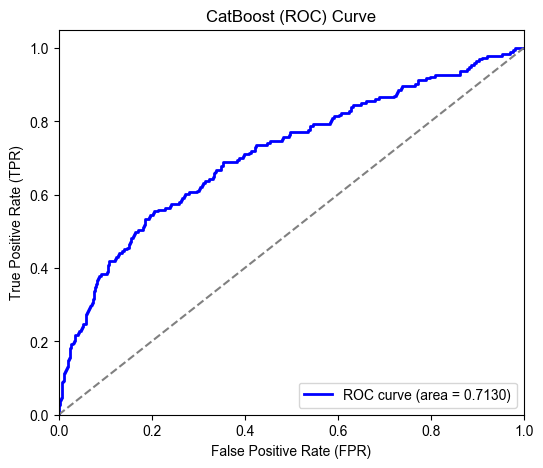

In [112]:
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns

X = phone_df[['agency',
'call_check',
'dmb',
'telecom_service_score',
'voice_service',
'data',
'cradit_card',
'data_service',
'marry',
'total_service_score',
'lifecycle_score',
'service_purchase',
'age',
'email',
'religion',
'financial_service_score',
'device_to_income_ratio',
'use_date']]
y = phone_df['churn']

# 학습/테스트 데이터 분리
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# CatBoost 모델 생성 및 학습
model = CatBoostClassifier(iterations=500, depth=6, learning_rate=0.1, loss_function='Logloss', verbose=100)
model.fit(X_train, y_train, eval_set=(X_test, y_test), early_stopping_rounds=50)

# 예측
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]  # 양성 클래스 확률

# 평가 지표 계산
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_prob)

# 오차 행렬
conf_matrix = confusion_matrix(y_test, y_pred)

# 결과 출력
print(f"📌 Accuracy: {accuracy:.4f}")
print(f"📌 Precision: {precision:.4f}")
print(f"📌 Recall: {recall:.4f}")
print(f"📌 F1-score: {f1:.4f}")
print(f"📌 ROC-AUC: {roc_auc:.4f}")
print("\n📌 Classification Report:\n", classification_report(y_test, y_pred))

# 오차 행렬 시각화
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Stayed (0)", "Churned (1)"], yticklabels=["Stayed (0)", "Churned (1)"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# ROC Curve 시각화
fpr, tpr, _ = roc_curve(y_test, y_prob)

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, color="blue", lw=2, label=f"ROC curve (area = {roc_auc:.4f})")
plt.plot([0, 1], [0, 1], color="gray", linestyle="--")  # 랜덤 모델 기준선
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.title("CatBoost (ROC) Curve")
plt.legend(loc="lower right")
plt.show()


# 1-3 CATBoost 오버샘플링

파생변수 + 기존 변수들 중 특성 중요도 높은 18개 변수로 학습 

0:	learn: 0.6439879	test: 0.6818697	best: 0.6818697 (0)	total: 2.55ms	remaining: 1.27s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.6673221011
bestIteration = 5

Shrink model to first 6 iterations.
📌 Accuracy: 0.7904
📌 Precision: 0.3087
📌 Recall: 0.4767
📌 F1-score: 0.3747
📌 ROC-AUC: 0.6932

📌 Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.84      0.87      1272
           1       0.31      0.48      0.37       193

    accuracy                           0.79      1465
   macro avg       0.61      0.66      0.62      1465
weighted avg       0.83      0.79      0.81      1465



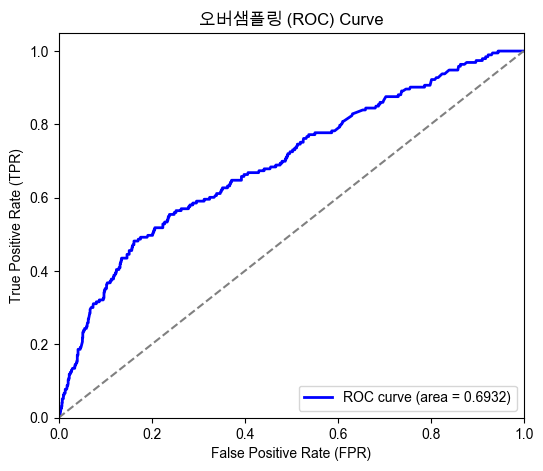

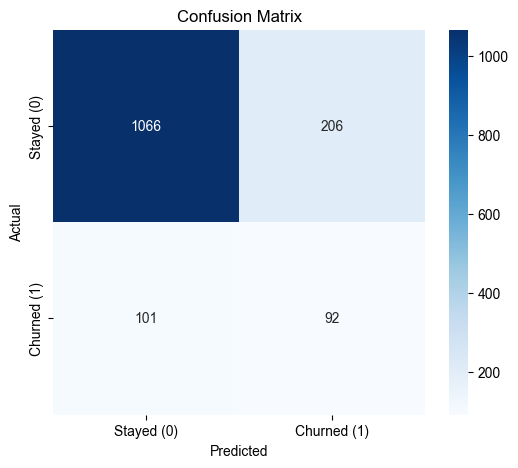

In [113]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report

# X, y 분리
X = phone_df[['agency',
'call_check',
'dmb',
'telecom_service_score',
'voice_service',
'data',
'cradit_card',
'data_service',
'marry',
'total_service_score',
'lifecycle_score',
'service_purchase',
'age',
'email',
'religion',
'financial_service_score',
'device_to_income_ratio',
'use_date']]
y = phone_df['churn']

# 학습/테스트 데이터 분리
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# SMOTE 오버샘플링
smote = SMOTE(sampling_strategy=0.5, random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

# CatBoost 모델 학습
model = CatBoostClassifier(iterations=500, depth=6, learning_rate=0.1, loss_function='Logloss', scale_pos_weight=6,  verbose=100)
model.fit(X_train_res, y_train_res, eval_set=(X_test, y_test), early_stopping_rounds=50)

# 예측
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]

# 추가⭐ 
from sklearn.metrics import precision_recall_curve
y_prob = model.predict_proba(X_test)[:, 1]
precisions, recalls, thresholds = precision_recall_curve(y_test, y_prob)

# 가장 적절한 지점 찾기 (F1-score 최대화)
f1_scores = (2 * precisions * recalls) / (precisions + recalls + 1e-9)
best_threshold = thresholds[f1_scores.argmax()]

# 최적 임계값 적용
y_pred = (y_prob > best_threshold).astype(int)
#⭐

# 평가 지표 계산
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_prob)

# 결과 출력
print(f"📌 Accuracy: {accuracy:.4f}")
print(f"📌 Precision: {precision:.4f}")
print(f"📌 Recall: {recall:.4f}")
print(f"📌 F1-score: {f1:.4f}")
print(f"📌 ROC-AUC: {roc_auc:.4f}")
print("\n📌 Classification Report:\n", classification_report(y_test, y_pred))

# ROC Curve 시각화
fpr, tpr, _ = roc_curve(y_test, y_prob)

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, color="blue", lw=2, label=f"ROC curve (area = {roc_auc:.4f})")
plt.plot([0, 1], [0, 1], color="gray", linestyle="--")  # 랜덤 모델 기준선
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.title("오버샘플링 (ROC) Curve")
plt.legend(loc="lower right")
plt.show()

# 오차 행렬
conf_matrix = confusion_matrix(y_test, y_pred)
# 오차 행렬 시각화
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Stayed (0)", "Churned (1)"], yticklabels=["Stayed (0)", "Churned (1)"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# 2-3 LGBM 오버샘플링

파생변수 + 기존 변수들 중 특성 중요도 높은 18개 변수로 학습 

[LightGBM] [Info] Number of positive: 2543, number of negative: 5087
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009650 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 441
[LightGBM] [Info] Number of data points in the train set: 7630, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
📌 Accuracy: 0.8177
📌 Precision: 0.3333
📌 Recall: 0.3834
📌 F1-score: 0.3566
📌 ROC-AUC: 0.7016

📌 Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.88      0.89      1272
           1       0.33      0.38      0.36       193

    accuracy                           0.82      1465
   macro avg       0.62      0.63      0.63      1465
weighted avg       0.83      0.82      0.82      1465



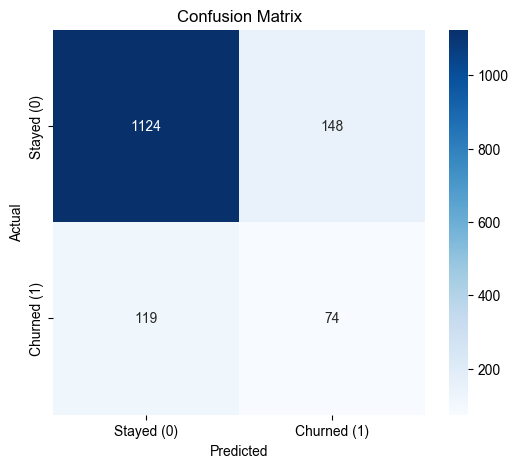

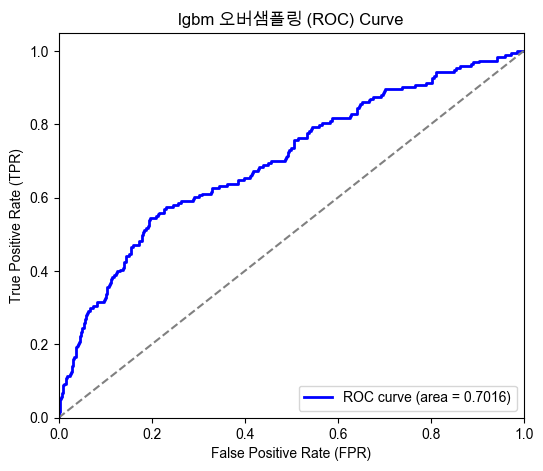

In [114]:
# SMOTE 오버샘플링
smote = SMOTE(sampling_strategy=0.5, random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

lgbm = LGBMClassifier(class_weight='balanced', num_leaves=31, learning_rate=0.05,
                      n_estimators=500, random_state=42)
lgbm.fit(X_train_res, y_train_res, eval_set=(X_test, y_test))

# 예측
y_pred = lgbm.predict(X_test)
y_prob = lgbm.predict_proba(X_test)[:, 1]  # 양성 클래스 확률

# 평가 지표 계산
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_prob)

# 오차 행렬
conf_matrix = confusion_matrix(y_test, y_pred)

# 결과 출력
print(f"📌 Accuracy: {accuracy:.4f}")
print(f"📌 Precision: {precision:.4f}")
print(f"📌 Recall: {recall:.4f}")
print(f"📌 F1-score: {f1:.4f}")
print(f"📌 ROC-AUC: {roc_auc:.4f}")
print("\n📌 Classification Report:\n", classification_report(y_test, y_pred))

# 오차 행렬 시각화
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Stayed (0)", "Churned (1)"], yticklabels=["Stayed (0)", "Churned (1)"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# ROC Curve 시각화
fpr, tpr, _ = roc_curve(y_test, y_prob)

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, color="blue", lw=2, label=f"ROC curve (area = {roc_auc:.4f})")
plt.plot([0, 1], [0, 1], color="gray", linestyle="--")  # 랜덤 모델 기준선
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.title("lgbm 오버샘플링 (ROC) Curve")
plt.legend(loc="lower right")
plt.show()

# 3-3 XGBoost 오버샘플링

파생변수 + 기존 변수들 중 특성 중요도 높은 18개 변수로 학습 

[0]	validation_0-logloss:1.19662
[1]	validation_0-logloss:1.17352
[2]	validation_0-logloss:1.15317
[3]	validation_0-logloss:1.13534
[4]	validation_0-logloss:1.11906
[5]	validation_0-logloss:1.10379
[6]	validation_0-logloss:1.09078
[7]	validation_0-logloss:1.07923
[8]	validation_0-logloss:1.06882
[9]	validation_0-logloss:1.05654
[10]	validation_0-logloss:1.04706
[11]	validation_0-logloss:1.03852
[12]	validation_0-logloss:1.03025
[13]	validation_0-logloss:1.02164
[14]	validation_0-logloss:1.01325
[15]	validation_0-logloss:1.00712
[16]	validation_0-logloss:1.00109
[17]	validation_0-logloss:0.99436
[18]	validation_0-logloss:0.98812
[19]	validation_0-logloss:0.98243
[20]	validation_0-logloss:0.97715
[21]	validation_0-logloss:0.97011
[22]	validation_0-logloss:0.96454
[23]	validation_0-logloss:0.95897
[24]	validation_0-logloss:0.95376
[25]	validation_0-logloss:0.94955
[26]	validation_0-logloss:0.94545
[27]	validation_0-logloss:0.93972
[28]	validation_0-logloss:0.93601
[29]	validation_0-loglos

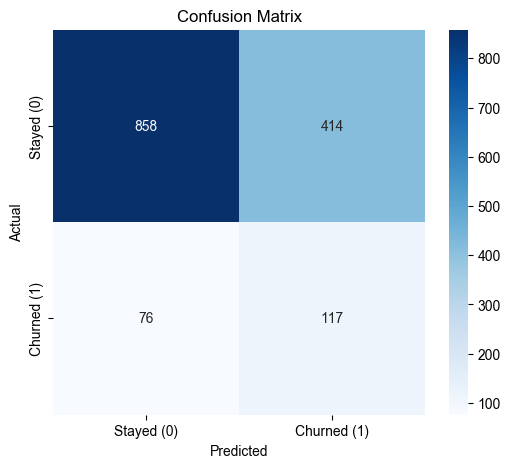

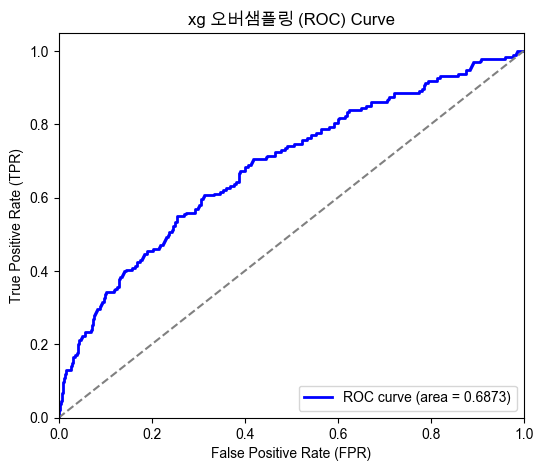

📌 Accuracy: 0.6655
📌 Precision: 0.2203
📌 Recall: 0.6062
📌 F1-score: 0.3232
📌 ROC-AUC: 0.6873

📌 Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.67      0.78      1272
           1       0.22      0.61      0.32       193

    accuracy                           0.67      1465
   macro avg       0.57      0.64      0.55      1465
weighted avg       0.83      0.67      0.72      1465



In [115]:
# SMOTE 오버샘플링
smote = SMOTE(sampling_strategy=0.5, random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

xgb = XGBClassifier(scale_pos_weight=len(y_train[y_train == 0]) / len(y_train[y_train == 1]),
                    max_depth=5, learning_rate=0.05, n_estimators=400, random_state=42)
xgb.fit(X_train_res, y_train_res, eval_set=[(X_test, y_test)])

# 예측
y_pred = xgb.predict(X_test)
y_prob = xgb.predict_proba(X_test)[:, 1]  # 양성 클래스 확률

# 평가 지표 계산
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_prob)

# 오차 행렬
conf_matrix = confusion_matrix(y_test, y_pred)


# 오차 행렬 시각화
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Stayed (0)", "Churned (1)"], yticklabels=["Stayed (0)", "Churned (1)"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# ROC Curve 시각화
fpr, tpr, _ = roc_curve(y_test, y_prob)

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, color="blue", lw=2, label=f"ROC curve (area = {roc_auc:.4f})")
plt.plot([0, 1], [0, 1], color="gray", linestyle="--")  # 랜덤 모델 기준선
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.title("xg 오버샘플링 (ROC) Curve")
plt.legend(loc="lower right")
plt.show()

# 결과 출력
print(f"📌 Accuracy: {accuracy:.4f}")
print(f"📌 Precision: {precision:.4f}")
print(f"📌 Recall: {recall:.4f}")
print(f"📌 F1-score: {f1:.4f}")
print(f"📌 ROC-AUC: {roc_auc:.4f}")
print("\n📌 Classification Report:\n", classification_report(y_test, y_pred))
